# ISPR 2025 - Midterm 3 - Assignament 2 - Gianluca Panzani (550358)

In [350]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
from torchvision import transforms

## Dataset class definition

Here is defined the Dataset class, which allows to iterate easily on the batches of the dataset, and some utility methods.

The size of the images has been standardized to 128x128 and the mean and the standard deviation of the images are computed to normalize them during the loading.

In [360]:
def get_img(img_dir: str, prefix: str, index: int, postfix: str, mask=False) -> Image:
    '''
    Get the image from the directory. The name of the image is composed as follows: "<img_dir><prefix>[<zeros>]<index><postfix>".
    The number of zeros is determined by the index.
    
    Parameters:
    - img_dir (str): directory where the images are stored.
    - prefix (str): prefix of the image name.
    - index (int): index of the image.
    - postfix (str): postfix of the image name.
    - mask (bool): is True if the image is a mask, False if the image is a normal image.

    Returns: the image as a PIL Image object.
    '''
    zeros = '00' if index < 10 else '0' if index < 100 else ''
    full_path = f'{img_dir}{prefix}{zeros}{index}{postfix}'
    if not mask:
        return Image.open(full_path).convert('RGB')
    return Image.open(full_path).convert('L')

def from_img_to_tensor(img: Image, resize_shape: tuple, mean=None, std=None) -> torch.Tensor:
    '''
    Convert the image to a tensor. Are applied normalization, if mean and std are provided, and resize.
    
    Parameters:
    - img (PIL.Image): image to be converted.
    - resize_shape (tuple): shape to resize the image to.
    - mean (list): mean values for normalization.
    - std (list): std values for normalization.

    Returns: the image as a tensor.
    '''
    if mean is not None and std is not None:
        if not (len(mean) == 3 and len(std) == 3):
            raise ValueError('The image has 3 channles. The parameters "mean" and "std" have to be lists with length equal to 3.')
        transform = transforms.Compose([
            transforms.Resize(resize_shape), # Resize
            transforms.ToTensor(), # Scaling
            transforms.Normalize(mean, std) # Normalization
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize(resize_shape), # Resize
            transforms.ToTensor() # Scaling
        ])
    return transform(img)
    
def from_mask_to_tensor(img: Image, resize_shape: tuple) -> torch.Tensor:
    '''
    Convert the mask to a tensor and resize is applied.
    
    Parameters:
    - img (PIL.Image): image to be converted.
    - resize_shape (tuple): shape to resize the image to.
    
    Returns: the image as a tensor.
    '''
    img = img.resize(resize_shape, resample=Image.NEAREST)
    img_np = np.array(img)
    if img_np.max() > 1:
        img_np = (img_np > 127).astype(np.uint8)
    tensor = torch.from_numpy(img_np).float().unsqueeze(0)  # shape: [1, H, W]
    return tensor

def get_mean_and_std(images_dir: str, img_prefix: str, img_postfix: str, resize_shape: tuple):
    '''
    Compute the mean and the standard deviation of all the images in the directory. The name of the image is composed as follows:
    "<img_dir><prefix>[<zeros>]<index><postfix>". The number of zeros is determined by the index, which is incremented until the image is not found.
    
    Parameters:
    - images_dir (str): directory where the images are stored.
    - img_prefix (str): prefix of the image name.
    - img_postfix (str): postfix of the image name.
    - resize_shape (tuple): shape to resize the image to.
    
    Returns:
    - mean (list): the mean of the images.
    - std (list): the standard deviation of the images.
    '''
    mean = torch.zeros(3)
    std = torch.zeros(3)
    i = 0
    while True:
        i += 1
        try:
            image = get_img(img_dir=images_dir, prefix=img_prefix, index=i, postfix=img_postfix, mask=False)
        except:
            break
        img = from_img_to_tensor(img=image, resize_shape=resize_shape)
        mean += img.mean(dim=(1, 2)) # Mean computed on each channel (e.g. with RGB -> [meanR,meanG,meanB])
        std += img.std(dim=(1, 2)) # Std computed on each channel (e.g. with RGB -> [stdR,stdG,stdB])
    mean = (mean / (i-1)).tolist()
    std = (std / (i-1)).tolist()
    return mean, std



class HorseSegmentationDataset(Dataset):
    def __init__(self, images_dir, img_prefix, img_postfix, masks_dir, mask_prefix, mask_postfix, resize_shape=(128,128)):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.img_prefix = img_prefix
        self.mask_prefix = mask_prefix
        self.img_postfix = img_postfix
        self.mask_postfix = mask_postfix
        self.resize_shape = resize_shape
        self.length = len(os.listdir(images_dir))
        mean, std = get_mean_and_std(
            images_dir=self.images_dir,
            img_prefix=self.img_prefix,
            img_postfix=self.img_postfix,
            resize_shape=self.resize_shape
        )
        self.mean = mean
        self.std = std

    def __getitem__(self, index):
        img = get_img(self.images_dir, self.img_prefix, index+1, self.img_postfix, mask=False)
        mask = get_img(self.masks_dir, self.mask_prefix, index+1, self.mask_postfix, mask=True)
        img_tensor = from_img_to_tensor(img, self.resize_shape, self.mean, self.std)
        mask_tensor = from_mask_to_tensor(mask, self.resize_shape)
        return img_tensor, mask_tensor
    
    def __len__(self):
        return self.length



# Creation of the dataset object
horse_dataset = HorseSegmentationDataset(
    images_dir='weizmann_horse_db/horse/',
    img_prefix='horse',
    img_postfix='.png',
    masks_dir='weizmann_horse_db/mask/',
    mask_prefix='horse',
    mask_postfix='.png',
    resize_shape=(128,128)
)

## Model class

In the following block, are implemented 2 classes: the ConvolutionalAE and the UNet.

Initially i had created the CAE architecture, but i have seen that results wasn't satisfiable and find better parameters was hard. In fact, with this architecture, i reached at most ~77% of IoU score. This is why i decided to implement a UNet too, which performed fastly better than the CAE. Both the implementations are dynamic, so that allowed me to use a Grid search to find the best combination of hyperparameters (which is described below).

To be more precise, i cited the CAE architecture for completeness in the explanation of my reasoning, but it's not used in the following code. The model selection is performed with the only use of the UNet class, just because the performances are considerably better (with respect to the ConvolutionalAE architecture).


## Architecture

The implemented architecture is a U-Net-based convolutional neural network designed for semantic segmentation. It consists of an encoder–decoder structure with skip connections.

The encoder is composed of a sequence of convolutional blocks, each followed by a downsampling operation via max pooling (in the forward pass). At the bottom of the "U" structure, there is the bottleneck block which doubles the number of channels. The decoder mirrors the encoder in reverse order: each stage begins with a transposed convolution for upsampling, followed by a convolutional block that reduces the number of channels. The final layer is a 1×1 convolution to map the features to a single-channel output with sigmoid activation function.

Each encoder-decoder block has two convolutional layers and two activation functions (ReLU or LeakyReLU).

Max Pooling is performed with a kernel size of 2 and a stride of 2, halving the spatial dimensions of the feature maps.

Skip connections are used to concatenate encoder features with decoder inputs at each corresponding resolution level.  
The interpolation is used during decoding (when the size of the skip connection is different to the size of the "x") to enforce the dimensions of the current image "x" to the size of the skip connection. The bilinear method was chosen for its effectiveness in 2D interpolation, and performs for each empty pixel a weighted mean of the 4 neighbors to chose the value to assign to it.

The padding in each convolutional block is set as half the dimension of the kernel.

In [ ]:
class ConvolutionalAE(nn.Module):
    def __init__(self, encoder_channels: list[int], decoder_channels: list[int], encoder_kernel_sizes: list[int], decoder_kernel_sizes: list[int],
                 encoder_strides: list[int], decoder_strides: list[int], output_padding: int):
        super(ConvolutionalAE, self).__init__()
        # Encoder architecture
        layers = []
        for i in range(len(encoder_channels)-1):
            k = encoder_kernel_sizes[i]
            s = encoder_strides[i]
            layers.append(nn.Conv2d(encoder_channels[i], encoder_channels[i+1], kernel_size=k, stride=s, padding=k//2))
            layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*layers)
        # Decoder architecture
        layers = []
        for i in range(len(decoder_channels)-2):
            k = decoder_kernel_sizes[i]
            s = decoder_strides[i]
            layers.append(nn.ConvTranspose2d(decoder_channels[i], decoder_channels[i+1], kernel_size=k, stride=s, padding=k//2, output_padding=output_padding))
            layers.append(nn.ReLU())
        layers.append(nn.ConvTranspose2d(decoder_channels[-2], decoder_channels[-1], kernel_size=decoder_kernel_sizes[-1], stride=decoder_strides[-1]))
        layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = F.interpolate(x, size=(128, 128), mode='bilinear', align_corners=False)
        return x
    



class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[32, 64, 128], kernel_size=3, activation='relu'):
        super(UNet, self).__init__()
        # Initializations
        self.kernel_size = kernel_size
        self.activation = activation
        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        # Encoder
        for feature in features:
            self.encoders.append(self._convolutional_block(in_channels, feature))
            in_channels = feature
        # Bottleneck
        self.bottleneck = self._convolutional_block(features[-1], 2*features[-1])
        # Decoder
        in_channels = 2*features[-1]
        for feature in features[::-1]: # Scans the list reversed (step=-1)
            self.decoders.append(nn.ConvTranspose2d(in_channels, feature, kernel_size=2, stride=2))
            self.decoders.append(self._convolutional_block(2*feature, feature))
            in_channels = feature
        # Final convolution
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        # Encoding
        skip_connections = []
        for encoder in self.encoders:
            x = encoder(x)
            skip_connections.append(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.bottleneck(x)
        # Decoding
        skip_connections = skip_connections[::-1]
        for i in range(0, len(self.decoders), 2):
            block1_index = i
            block2_index = i+1
            x = self.decoders[block1_index](x) # Transposed Convolutional block
            x_skip = skip_connections[i//2]
            if x.shape != x_skip.shape: # Case of interpolation
                x = F.interpolate(x, size=x_skip.shape[2:]) # (A, B, H, W) -> (A, B, H', W')
            x = torch.cat((x_skip, x), dim=1)
            x = self.decoders[block2_index](x) # Convolutional block
        # Final convolution
        x = self.final_conv(x)
        return torch.sigmoid(x)

    def _convolutional_block(self, in_channels, out_channels):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=self.kernel_size, padding=self.kernel_size//2),
            self._get_activation(),
            nn.Conv2d(out_channels, out_channels, kernel_size=self.kernel_size, padding=self.kernel_size//2),
            self._get_activation(),
        ]
        return nn.Sequential(*layers)

    def _get_activation(self):
        if self.activation == 'relu':
            return nn.ReLU(inplace=True)
        elif self.activation == 'leaky_relu':
            return nn.LeakyReLU(inplace=True)
        else:
            raise ValueError(f'Unsupported activation: {self.activation}')

## Training method

The training method performs both the training and validation phases. During each epoch, it computes the loss on the training set, the loss on the validation set, and the Intersection over Union (IoU) score.

IoU measures the overlap between the predicted mask and actual mask, and is commonly used as accuracy metric in segmentation tasks.

The early stopping is implemented to avoid overfitting and it's performed in two cases:
- when the mean of the last "k" IoU scores of the current iteration minus the mean of the best consecutive "k" IoU scores is minor than the "threshold" for "tolerance" consecutive epochs.
- when the difference between the training loss and the validation loss is higher than 10%.

In [390]:
def iou(preds: torch.Tensor, masks: torch.Tensor) -> float:
    '''
    Computes the Intersection over Union (IoU) score between the predicted masks and the actual masks.

    Parameters:
    - preds: the predicted masks (output of the model).
    - masks: the actual masks (ground truth).

    Returns:
    - iou_score: the IoU score.
    '''
    preds = (preds > 0.5).float()
    masks = (masks > 0.5).float()
    # Compute intersection and union
    intersection = (preds * masks).sum()
    union = ((preds + masks) > 0).float().sum()
    # Case of empty union (the predictions and the masks are empty, so equal)
    if union == 0:
        return 1.0
    iou_score = intersection / union
    return iou_score.item()



def train(model: nn.Module, tr_dataloader: DataLoader, vl_dataloader: DataLoader, optimizer, criterion, device, epochs, threshold, tolerance, verbose=1):
    '''
    Performs the training and the validation of the model.

    Parameters:
    - model: the model to train.
    - tr_dataloader: the training set.
    - vl_dataloader: the validation set.
    - optimizer: the optimizer to use.
    - criterion: the loss function to use.
    - device: the device to use (CPU or GPU).
    - epochs: the number of epochs.
    - threshold: the threshold to use for early stopping.
    - tolerance: the number of epochs of tolerance for early stopping.
    - verbose: the verbosity level (0 = no output, 1 = output every epoch).

    Returns:
    - tr_losses: the training losses list.
    - vl_losses: the validation losses list.
    - iou_scores: the IoU scores list.
    '''
    model.to(device)

    # Initializations
    k = 5
    patience = 0
    best_mean_iou_avg_score = 0
    tr_losses = []
    vl_losses = []
    iou_scores = []

    # Iterate on the epochs
    for epoch in range(epochs):

        # Training phase
        model.train()
        total_loss = 0.0
        for imgs, masks in tr_dataloader:
            imgs = imgs.to(device)          # Move images' tensors on GPU or CPU
            masks = masks.to(device)        # Move masks' tensors on GPU or CPU

            preds = model(imgs)             # Compute the predictions
            loss = criterion(preds, masks)  # Compute the loss
            optimizer.zero_grad()           # Reset the gradients
            loss.backward()                 # Perform backpropagation
            optimizer.step()                # Update model's parameters (based on gradients)

            total_loss += loss.item()       # Update total loss with the average loss on this batch

        tr_avg_loss = total_loss / len(tr_dataloader)
        tr_losses.append(tr_avg_loss)

        # Validation phase
        model.eval()
        with torch.no_grad():
            total_loss = 0.0
            total_iou = 0.0

            for imgs, masks in vl_dataloader:
                imgs = imgs.to(device)
                masks = masks.to(device)

                preds = model(imgs)
                loss = criterion(preds, masks)

                total_loss += loss.item()
                total_iou += iou(preds, masks)

        vl_avg_loss = total_loss / len(vl_dataloader)
        vl_losses.append(vl_avg_loss)
        iou_avg_score = total_iou / len(vl_dataloader)
        iou_scores.append(iou_avg_score)

        # Print of the epoch result
        if verbose > 0:
            print(f'Epoch {epoch+1}/{epochs}: TR_loss={tr_avg_loss:.4f} - VL_loss={vl_avg_loss:.4f} - IoU={iou_avg_score:.4f}')
        
        # Early stopping (based on IoU score)
        current_mean_iou_avg_score = np.mean(iou_scores[-k:])
        if epoch > k and (current_mean_iou_avg_score - best_mean_iou_avg_score < threshold or vl_avg_loss - tr_avg_loss > 0.1):
            patience += 1
        else:
            patience = 0
        if patience > tolerance:
            if verbose > 0:
                print(f'Early stopping at epoch {epoch+1}')
            break
        if best_mean_iou_avg_score < current_mean_iou_avg_score:
            best_mean_iou_avg_score = current_mean_iou_avg_score
    
    return tr_losses, vl_losses, iou_scores

## Grid search

The hyperparameters on which the Grid search is performed (for UNet architecture) are:
- batch_size
- learning_rate
- epochs
- activation: the activation function to use.
- threshold: the threshold used for the condition of Early stopping.
- tolerance: the number of epochs of tolerence for the Early stopping.
- kernel_size: the dimension of the kernel, which will be a squared matrix of dimension kernel_size.
- features: the number of features in the output for each convolutional block.

For example if features=[32,64,128] means that the decoder will has 3 layers and the number of channels that their outputs have are respectively 32, 64 and 128. The decoder is equal the encoder but reversed, as already described. The rest of the parameters are enough self-explanatory.

In [ ]:
# Space of the hyperparameters for ConvolutionalAE
params_space = { # ignored parameters (not used in the model)
    'batch_size': [16, 32, 64],
    'learning_rate': [0.0001, 0.001],
    'epochs': [75],
    'threshold': [0.0001],
    'tolerance': [10],
    'architecture': [
        {
            'encoder_channels': [3,32,64], 'encoder_kernel_sizes': [3,3,3], 'encoder_strides': [2,2,2],
            'decoder_channels': [64,32,1], 'decoder_kernel_sizes': [3,3,3], 'decoder_strides': [2,2,2],
            'output_padding': 1
        },
        {
            'encoder_channels': [3,32,64], 'encoder_kernel_sizes': [3,3,5], 'encoder_strides': [2,2,1],
            'decoder_channels': [64,32,1], 'decoder_kernel_sizes': [5,3,3], 'decoder_strides': [1,2,2],
            'output_padding': 0
        },
        {
            'encoder_channels': [3,32,64,128], 'encoder_kernel_sizes': [3,3,3,3], 'encoder_strides': [2,2,2,1],
            'decoder_channels': [128,64,32,1], 'decoder_kernel_sizes': [3,3,3,3], 'decoder_strides': [1,2,2,2],
            'output_padding': 0
        },
        {
            'encoder_channels': [3,32,64,128,256], 'encoder_kernel_sizes': [3,3,3,3,3], 'encoder_strides': [2,2,2,2,1],
            'decoder_channels': [256,128,64,32,1], 'decoder_kernel_sizes': [3,3,3,3,3], 'decoder_strides': [1,2,2,2,2],
            'output_padding': 0
        }
    ]
}

# Space of the hyperparameters for UNet
params_space = {
    'batch_size': [8, 16],
    'learning_rate': [0.0001, 0.001],
    'epochs': [150],
    'threshold': [0.0005],
    'tolerance': [7],
    'activation': ['relu', 'leaky_relu'],
    'kernel_size': [3, 5],
    'features': [[32, 64, 128], [32, 64, 128, 256]]
}

## Model selection

Given the dictionary of parameters lists, the code generates all the possible hyperparameters combinations. For each one is instantiated a model, which is trained.

The best model is chosen based on the mean of the last 3 IoU scores retured by the training function. The one with the maximum mean is selected for the testing phase.
The use of the mean is due to the fluctuation of the IoU score, in this way the evaluation is more consistent with respect to the simple comparison between the last IoU score of the two models.

For each parameters combination is created a model and, during training, are printed loss and IoU score on each epoch.

Hyperparameters [1/24]: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [64, 128, 256]}
Epoch 1/150: TR_loss=0.6429 - VL_loss=0.5798 - IoU=0.0000
Epoch 2/150: TR_loss=0.5563 - VL_loss=0.5312 - IoU=0.0000
Epoch 3/150: TR_loss=0.4802 - VL_loss=0.4716 - IoU=0.3705
Epoch 4/150: TR_loss=0.4063 - VL_loss=0.3669 - IoU=0.4853
Epoch 5/150: TR_loss=0.3409 - VL_loss=0.3310 - IoU=0.5609
Epoch 6/150: TR_loss=0.3276 - VL_loss=0.3099 - IoU=0.5628
Epoch 7/150: TR_loss=0.2990 - VL_loss=0.2899 - IoU=0.6200
Epoch 8/150: TR_loss=0.2760 - VL_loss=0.2797 - IoU=0.6051
Epoch 9/150: TR_loss=0.2529 - VL_loss=0.2479 - IoU=0.6695
Epoch 10/150: TR_loss=0.2325 - VL_loss=0.2281 - IoU=0.6908
Epoch 11/150: TR_loss=0.2288 - VL_loss=0.2238 - IoU=0.6960
Epoch 12/150: TR_loss=0.2100 - VL_loss=0.2329 - IoU=0.6526
Epoch 13/150: TR_loss=0.2032 - VL_loss=0.2409 - IoU=0.6341
Epoch 14/150: TR_loss=0.1917 - VL_loss=0.2389 - IoU=0.7

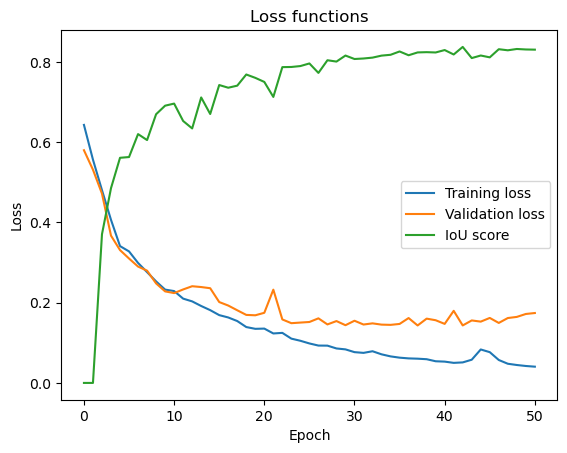


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [64, 128, 256]}
- IoU score=0.8310972281864711
- Loss=0.1741640642285347
Hyperparameters [2/24]: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [64, 128, 256]}
Epoch 1/150: TR_loss=0.6610 - VL_loss=0.6048 - IoU=0.0000
Epoch 2/150: TR_loss=0.5886 - VL_loss=0.5515 - IoU=0.0000
Epoch 3/150: TR_loss=0.5506 - VL_loss=0.5323 - IoU=0.0000
Epoch 4/150: TR_loss=0.5056 - VL_loss=0.4742 - IoU=0.1873
Epoch 5/150: TR_loss=0.4197 - VL_loss=0.3833 - IoU=0.4283
Epoch 6/150: TR_loss=0.3628 - VL_loss=0.3569 - IoU=0.5899
Epoch 7/150: TR_loss=0.3576 - VL_loss=0.3666 - IoU=0.6139
Epoch 8/150: TR_loss=0.3414 - VL_loss=0.3341 - IoU=0.5275
Epoch 9/150: TR_loss=0.3072 - VL_loss=0.2828 - IoU=0.6470
Epoch 10/150: TR_loss=0.2893 - VL_loss=

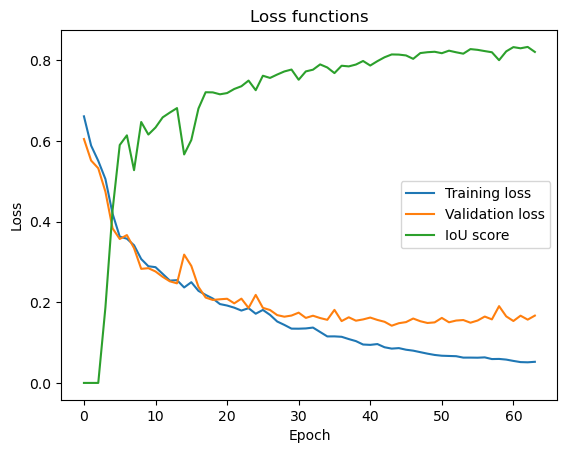


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [64, 128, 256]}
- IoU score=0.8310972281864711
- Loss=0.1741640642285347
Hyperparameters [3/24]: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [64, 128, 256]}
Epoch 1/150: TR_loss=0.6861 - VL_loss=0.5648 - IoU=0.0000
Epoch 2/150: TR_loss=0.5208 - VL_loss=0.4736 - IoU=0.0006
Epoch 3/150: TR_loss=0.4506 - VL_loss=0.4536 - IoU=0.4687
Epoch 4/150: TR_loss=0.4429 - VL_loss=0.4471 - IoU=0.4512
Epoch 5/150: TR_loss=0.4319 - VL_loss=0.4189 - IoU=0.3945
Epoch 6/150: TR_loss=0.4085 - VL_loss=0.4218 - IoU=0.4909
Epoch 7/150: TR_loss=0.3963 - VL_loss=0.4120 - IoU=0.4928
Epoch 8/150: TR_loss=0.3857 - VL_loss=0.3861 - IoU=0.4567
Epoch 9/150: TR_loss=0.3837 - VL_loss=0.3862 - IoU=0.4988
Epoch 10/150: TR_loss=0.3708 - VL_loss=0.

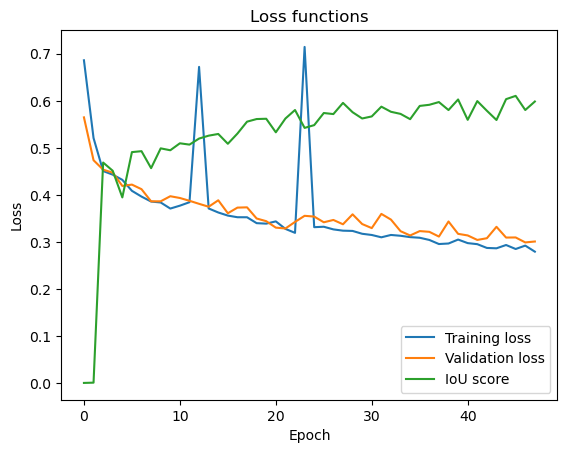


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [64, 128, 256]}
- IoU score=0.8310972281864711
- Loss=0.1741640642285347
Hyperparameters [4/24]: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [64, 128, 256]}
Epoch 1/150: TR_loss=0.5653 - VL_loss=0.5038 - IoU=0.0000
Epoch 2/150: TR_loss=0.4799 - VL_loss=0.4711 - IoU=0.2759
Epoch 3/150: TR_loss=0.4311 - VL_loss=0.4352 - IoU=0.4811
Epoch 4/150: TR_loss=0.4173 - VL_loss=0.4650 - IoU=0.5364
Epoch 5/150: TR_loss=0.4104 - VL_loss=0.3951 - IoU=0.5086
Epoch 6/150: TR_loss=0.7118 - VL_loss=0.4409 - IoU=0.3152
Epoch 7/150: TR_loss=0.4461 - VL_loss=0.4169 - IoU=0.4775
Epoch 8/150: TR_loss=0.4473 - VL_loss=0.4505 - IoU=0.4498
Epoch 9/150: TR_loss=0.4102 - VL_loss=0.3678 - IoU=0.5480
Epoch 10/150: TR_loss=0.3482 - VL_loss=0

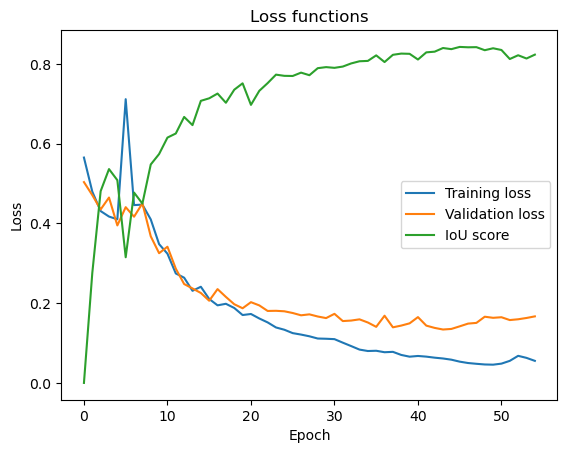


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [64, 128, 256]}
- IoU score=0.8310972281864711
- Loss=0.1741640642285347
Hyperparameters [5/24]: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [64, 128, 256]}
Epoch 1/150: TR_loss=0.5820 - VL_loss=0.5221 - IoU=0.1718
Epoch 2/150: TR_loss=0.4555 - VL_loss=0.3624 - IoU=0.5405
Epoch 3/150: TR_loss=0.3947 - VL_loss=0.3572 - IoU=0.5664
Epoch 4/150: TR_loss=0.3228 - VL_loss=0.2978 - IoU=0.6184
Epoch 5/150: TR_loss=0.2905 - VL_loss=0.3081 - IoU=0.5553
Epoch 6/150: TR_loss=0.2936 - VL_loss=0.2888 - IoU=0.5811
Epoch 7/150: TR_loss=0.2598 - VL_loss=0.2664 - IoU=0.6630
Epoch 8/150: TR_loss=0.2408 - VL_loss=0.2496 - IoU=0.6720
Epoch 9/150: TR_loss=0.2169 - VL_loss=0.2262 - IoU=0.6970
Epoch 10/150: TR_loss=0.2104 - VL_loss=0

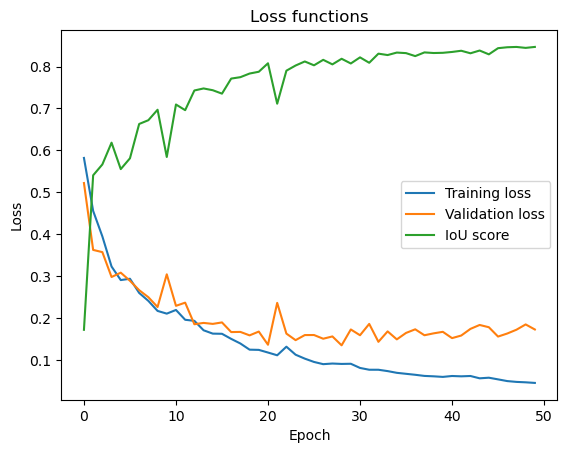


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [64, 128, 256]}
- IoU score=0.8461340807733082
- Loss=0.17252816366297857
Hyperparameters [6/24]: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [64, 128, 256]}
Epoch 1/150: TR_loss=0.6207 - VL_loss=0.5533 - IoU=0.0000
Epoch 2/150: TR_loss=0.5608 - VL_loss=0.5254 - IoU=0.0000
Epoch 3/150: TR_loss=0.5068 - VL_loss=0.4797 - IoU=0.0385
Epoch 4/150: TR_loss=0.4231 - VL_loss=0.3779 - IoU=0.5016
Epoch 5/150: TR_loss=0.3500 - VL_loss=0.3287 - IoU=0.6133
Epoch 6/150: TR_loss=0.3386 - VL_loss=0.3770 - IoU=0.4594
Epoch 7/150: TR_loss=0.3082 - VL_loss=0.2989 - IoU=0.5926
Epoch 8/150: TR_loss=0.2876 - VL_loss=0.3095 - IoU=0.5674
Epoch 9/150: TR_loss=0.2666 - VL_loss=0.2646 - IoU=0.6587
Epoch 10/150: TR_loss=0.2479 - VL_loss

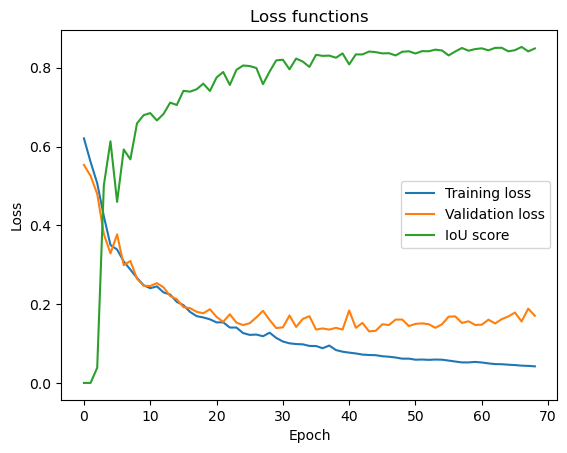


Best model:
- Hyperparameters={'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [64, 128, 256]}
- IoU score=0.8477381616830826
- Loss=0.17041784524917603
Hyperparameters [7/24]: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [64, 128, 256]}
Epoch 1/150: TR_loss=1.1908 - VL_loss=0.6090 - IoU=0.0000
Epoch 2/150: TR_loss=0.5157 - VL_loss=0.4575 - IoU=0.0000
Epoch 3/150: TR_loss=0.4372 - VL_loss=0.3992 - IoU=0.0523
Epoch 4/150: TR_loss=0.3984 - VL_loss=0.3731 - IoU=0.2335
Epoch 5/150: TR_loss=0.3409 - VL_loss=0.3262 - IoU=0.5959
Epoch 6/150: TR_loss=0.2940 - VL_loss=0.2820 - IoU=0.6115
Epoch 7/150: TR_loss=0.2675 - VL_loss=0.2925 - IoU=0.6174
Epoch 8/150: TR_loss=0.2787 - VL_loss=0.2752 - IoU=0.6556
Epoch 9/150: TR_loss=0.2361 - VL_loss=0.2583 - IoU=0.6390
Epoch 10/150: TR_loss=0.2157 - VL_loss=

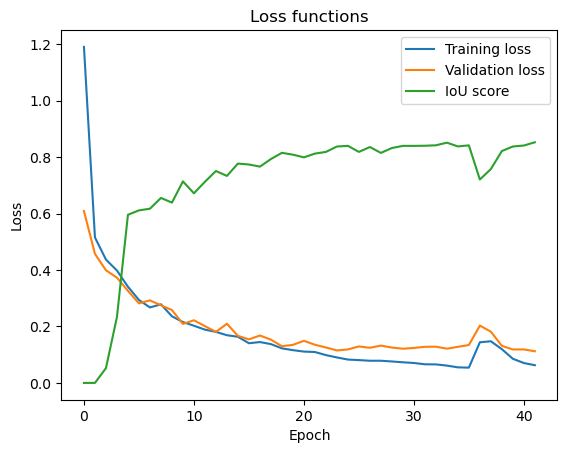


Best model:
- Hyperparameters={'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [64, 128, 256]}
- IoU score=0.8477381616830826
- Loss=0.17041784524917603
Hyperparameters [8/24]: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [64, 128, 256]}
Epoch 1/150: TR_loss=1.6760 - VL_loss=0.5326 - IoU=0.3328
Epoch 2/150: TR_loss=0.4531 - VL_loss=0.5802 - IoU=0.3896
Epoch 3/150: TR_loss=0.5280 - VL_loss=0.4684 - IoU=0.4341
Epoch 4/150: TR_loss=0.4350 - VL_loss=0.4650 - IoU=0.3770
Epoch 5/150: TR_loss=0.4645 - VL_loss=0.4474 - IoU=0.4301
Epoch 6/150: TR_loss=0.4037 - VL_loss=0.3863 - IoU=0.5997
Epoch 7/150: TR_loss=0.3472 - VL_loss=0.4076 - IoU=0.5508
Epoch 8/150: TR_loss=0.3688 - VL_loss=0.3515 - IoU=0.6388
Epoch 9/150: TR_loss=0.3067 - VL_loss=0.2771 - IoU=0.6657
Epoch 10/150: TR_loss=0.2810 - VL_loss

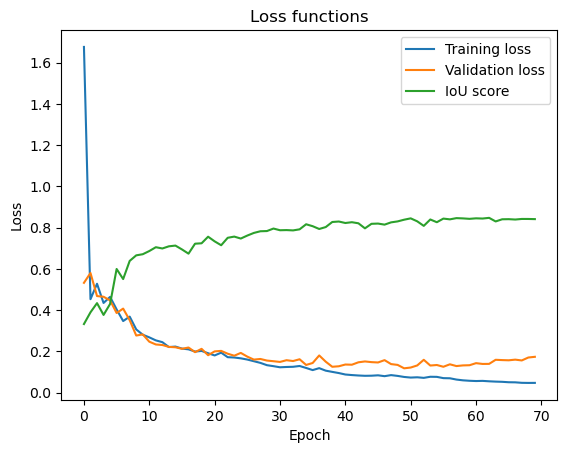


Best model:
- Hyperparameters={'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [64, 128, 256]}
- IoU score=0.8477381616830826
- Loss=0.17041784524917603
Hyperparameters [9/24]: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.6408 - VL_loss=0.6131 - IoU=0.0000
Epoch 2/150: TR_loss=0.5731 - VL_loss=0.5450 - IoU=0.0259
Epoch 3/150: TR_loss=0.5221 - VL_loss=0.4997 - IoU=0.3147
Epoch 4/150: TR_loss=0.4523 - VL_loss=0.4006 - IoU=0.3833
Epoch 5/150: TR_loss=0.3732 - VL_loss=0.3543 - IoU=0.5122
Epoch 6/150: TR_loss=0.3491 - VL_loss=0.3348 - IoU=0.5336
Epoch 7/150: TR_loss=0.3240 - VL_loss=0.3384 - IoU=0.5775
Epoch 8/150: TR_loss=0.3083 - VL_loss=0.3347 - IoU=0.5947
Epoch 9/150: TR_loss=0.3104 - VL_loss=0.3061 - IoU=0.5492
Epoch 10/150: TR_loss=0.2875 - VL_loss=

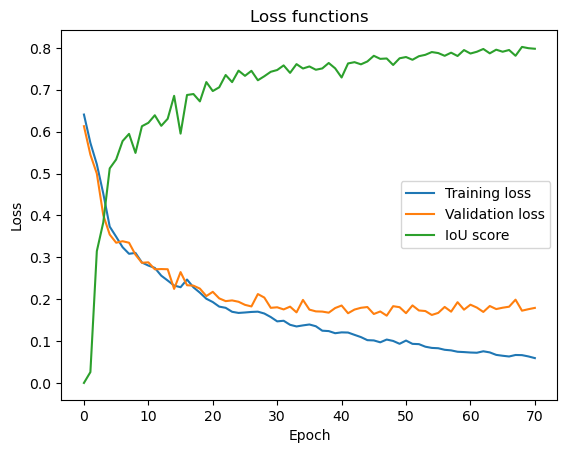


Best model:
- Hyperparameters={'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [64, 128, 256]}
- IoU score=0.8477381616830826
- Loss=0.17041784524917603
Hyperparameters [10/24]: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.6892 - VL_loss=0.6789 - IoU=0.0000
Epoch 2/150: TR_loss=0.6613 - VL_loss=0.6326 - IoU=0.0000
Epoch 3/150: TR_loss=0.6042 - VL_loss=0.5835 - IoU=0.0000
Epoch 4/150: TR_loss=0.5595 - VL_loss=0.5585 - IoU=0.0000
Epoch 5/150: TR_loss=0.5361 - VL_loss=0.5222 - IoU=0.0008
Epoch 6/150: TR_loss=0.5050 - VL_loss=0.4816 - IoU=0.2039
Epoch 7/150: TR_loss=0.4488 - VL_loss=0.4459 - IoU=0.3490
Epoch 8/150: TR_loss=0.3958 - VL_loss=0.3878 - IoU=0.4617
Epoch 9/150: TR_loss=0.3655 - VL_loss=0.3609 - IoU=0.5079
Epoch 10/150: TR_loss=0.3355 - VL_los

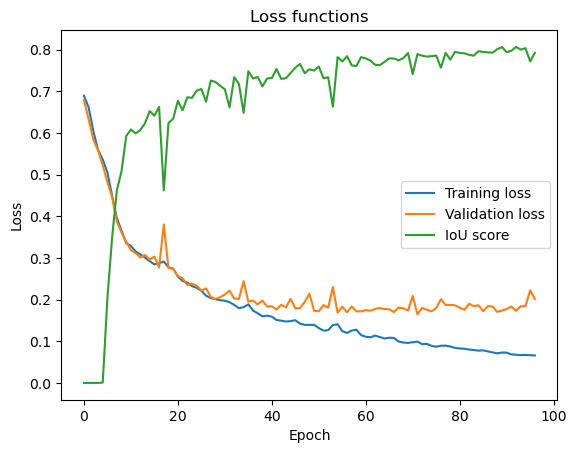


Best model:
- Hyperparameters={'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [64, 128, 256]}
- IoU score=0.8477381616830826
- Loss=0.17041784524917603
Hyperparameters [11/24]: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.5822 - VL_loss=0.4907 - IoU=0.0000
Epoch 2/150: TR_loss=0.4618 - VL_loss=0.4582 - IoU=0.3728
Epoch 3/150: TR_loss=0.4770 - VL_loss=0.4428 - IoU=0.3553
Epoch 4/150: TR_loss=0.4189 - VL_loss=0.4365 - IoU=0.4800
Epoch 5/150: TR_loss=0.3734 - VL_loss=0.3292 - IoU=0.5718
Epoch 6/150: TR_loss=0.3787 - VL_loss=0.3578 - IoU=0.5390
Epoch 7/150: TR_loss=0.3774 - VL_loss=0.3805 - IoU=0.4862
Epoch 8/150: TR_loss=0.3381 - VL_loss=0.3294 - IoU=0.5831
Epoch 9/150: TR_loss=0.2933 - VL_loss=0.2775 - IoU=0.6472
Epoch 10/150: TR_loss=0.2766 - VL_loss=

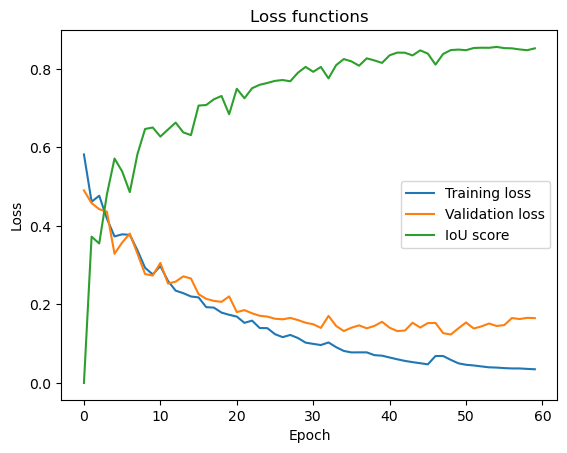


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8501791329610916
- Loss=0.16505464805024012
Hyperparameters [12/24]: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.6130 - VL_loss=0.5500 - IoU=0.0000
Epoch 2/150: TR_loss=0.5391 - VL_loss=0.5071 - IoU=0.0000
Epoch 3/150: TR_loss=0.4633 - VL_loss=0.4814 - IoU=0.2718
Epoch 4/150: TR_loss=0.4393 - VL_loss=0.4281 - IoU=0.5031
Epoch 5/150: TR_loss=0.4168 - VL_loss=0.3907 - IoU=0.5417
Epoch 6/150: TR_loss=0.3876 - VL_loss=0.3786 - IoU=0.5061
Epoch 7/150: TR_loss=0.3514 - VL_loss=0.3381 - IoU=0.5787
Epoch 8/150: TR_loss=0.3182 - VL_loss=0.3333 - IoU=0.6080
Epoch 9/150: TR_loss=0.3250 - VL_loss=0.4385 - IoU=0.5177
Epoch 10/150: TR_loss=0.3323 - VL_loss=0.

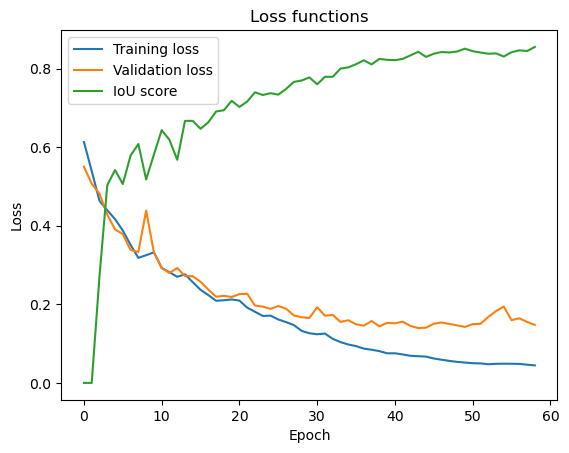


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8501791329610916
- Loss=0.16505464805024012
Hyperparameters [13/24]: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.6372 - VL_loss=0.5863 - IoU=0.0000
Epoch 2/150: TR_loss=0.5600 - VL_loss=0.5324 - IoU=0.0000
Epoch 3/150: TR_loss=0.4543 - VL_loss=0.4231 - IoU=0.4154
Epoch 4/150: TR_loss=0.3958 - VL_loss=0.3724 - IoU=0.5678
Epoch 5/150: TR_loss=0.3353 - VL_loss=0.3165 - IoU=0.6082
Epoch 6/150: TR_loss=0.3113 - VL_loss=0.3394 - IoU=0.6079
Epoch 7/150: TR_loss=0.2905 - VL_loss=0.2952 - IoU=0.6420
Epoch 8/150: TR_loss=0.2708 - VL_loss=0.2968 - IoU=0.6517
Epoch 9/150: TR_loss=0.2572 - VL_loss=0.2521 - IoU=0.6743
Epoch 10/150: TR_loss=0.2346 - VL_loss=0.

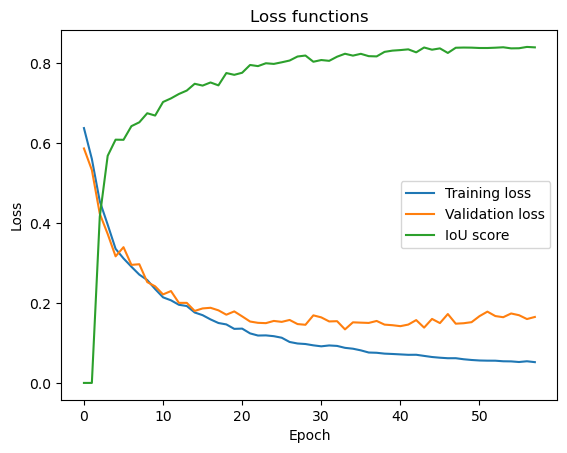


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8501791329610916
- Loss=0.16505464805024012
Hyperparameters [14/24]: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.6969 - VL_loss=0.6218 - IoU=0.0000
Epoch 2/150: TR_loss=0.6028 - VL_loss=0.5628 - IoU=0.0000
Epoch 3/150: TR_loss=0.5646 - VL_loss=0.5424 - IoU=0.0000
Epoch 4/150: TR_loss=0.5261 - VL_loss=0.5145 - IoU=0.1564
Epoch 5/150: TR_loss=0.4892 - VL_loss=0.4793 - IoU=0.3046
Epoch 6/150: TR_loss=0.4286 - VL_loss=0.3889 - IoU=0.5502
Epoch 7/150: TR_loss=0.3797 - VL_loss=0.3675 - IoU=0.4904
Epoch 8/150: TR_loss=0.3419 - VL_loss=0.3156 - IoU=0.6190
Epoch 9/150: TR_loss=0.3011 - VL_loss=0.2960 - IoU=0.6148
Epoch 10/150: TR_loss=0.2780 - VL_loss=0

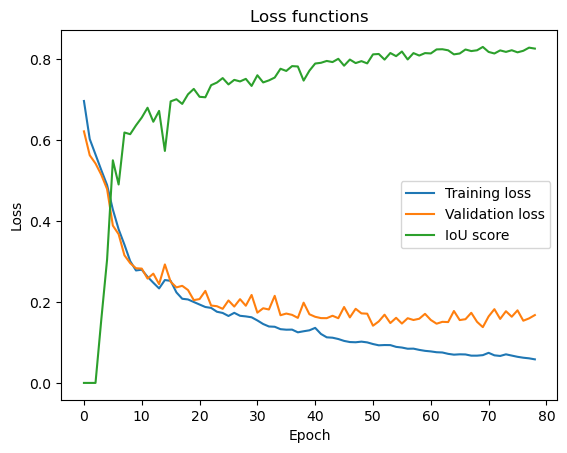


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8501791329610916
- Loss=0.16505464805024012
Hyperparameters [15/24]: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.5167 - VL_loss=0.4757 - IoU=0.0000
Epoch 2/150: TR_loss=0.4672 - VL_loss=0.4497 - IoU=0.0000
Epoch 3/150: TR_loss=0.4079 - VL_loss=0.4175 - IoU=0.2773
Epoch 4/150: TR_loss=0.4216 - VL_loss=0.3989 - IoU=0.4497
Epoch 5/150: TR_loss=0.3163 - VL_loss=0.2951 - IoU=0.6110
Epoch 6/150: TR_loss=0.2646 - VL_loss=0.2594 - IoU=0.6450
Epoch 7/150: TR_loss=0.2414 - VL_loss=0.2774 - IoU=0.5431
Epoch 8/150: TR_loss=0.2465 - VL_loss=0.2508 - IoU=0.6778
Epoch 9/150: TR_loss=0.2321 - VL_loss=0.2121 - IoU=0.7095
Epoch 10/150: TR_loss=0.2149 - VL_loss=0.2

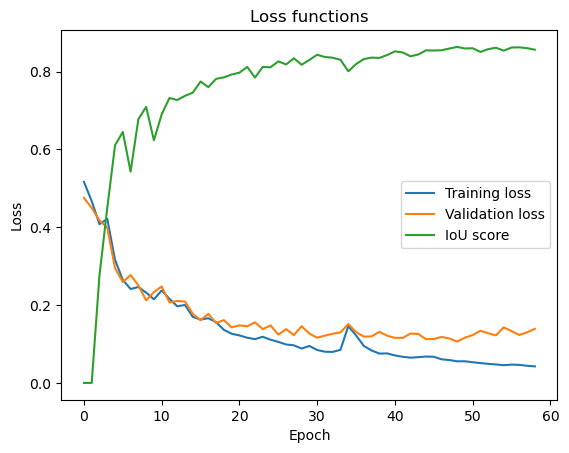


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
- IoU score=0.8598010398092724
- Loss=0.1389890174780573
Hyperparameters [16/24]: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.5727 - VL_loss=0.4748 - IoU=0.0000
Epoch 2/150: TR_loss=0.4743 - VL_loss=0.4451 - IoU=0.4538
Epoch 3/150: TR_loss=0.4473 - VL_loss=0.3880 - IoU=0.2889
Epoch 4/150: TR_loss=0.4062 - VL_loss=0.4082 - IoU=0.5481
Epoch 5/150: TR_loss=0.3930 - VL_loss=0.3702 - IoU=0.5758
Epoch 6/150: TR_loss=0.3525 - VL_loss=0.3127 - IoU=0.5893
Epoch 7/150: TR_loss=0.3199 - VL_loss=0.2643 - IoU=0.6650
Epoch 8/150: TR_loss=0.3103 - VL_loss=0.2938 - IoU=0.6376
Epoch 9/150: TR_loss=0.2824 - VL_loss=0.2630 - IoU=0.6442
Epoch 10/150: TR_loss=0.2429 - VL_loss=0.2

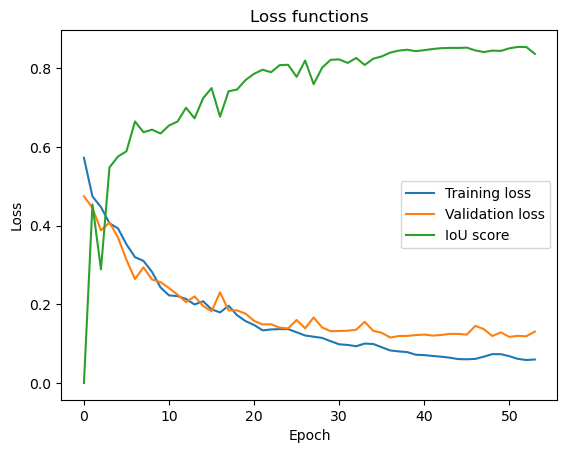


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
- IoU score=0.8598010398092724
- Loss=0.1389890174780573
Hyperparameters [17/24]: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.6786 - VL_loss=0.6630 - IoU=0.0000
Epoch 2/150: TR_loss=0.6142 - VL_loss=0.5798 - IoU=0.0000
Epoch 3/150: TR_loss=0.5181 - VL_loss=0.4602 - IoU=0.0801
Epoch 4/150: TR_loss=0.4134 - VL_loss=0.3977 - IoU=0.4762
Epoch 5/150: TR_loss=0.3643 - VL_loss=0.3704 - IoU=0.5684
Epoch 6/150: TR_loss=0.3201 - VL_loss=0.3225 - IoU=0.5595
Epoch 7/150: TR_loss=0.2840 - VL_loss=0.2826 - IoU=0.6254
Epoch 8/150: TR_loss=0.2769 - VL_loss=0.2824 - IoU=0.6495
Epoch 9/150: TR_loss=0.2536 - VL_loss=0.2557 - IoU=0.6679
Epoch 10/150: TR_loss=0.2390 - VL_los

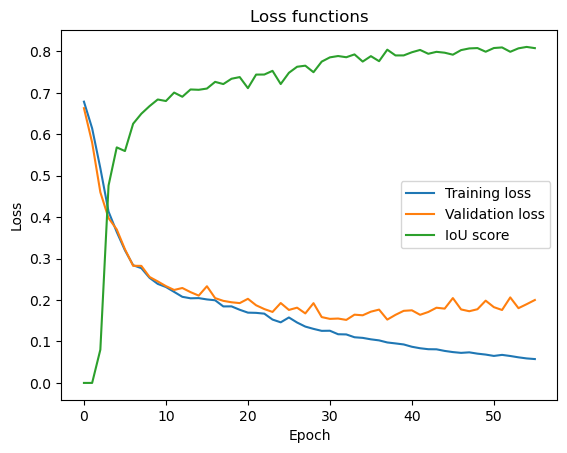


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
- IoU score=0.8598010398092724
- Loss=0.1389890174780573
Hyperparameters [18/24]: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.6681 - VL_loss=0.6579 - IoU=0.0000
Epoch 2/150: TR_loss=0.6431 - VL_loss=0.6088 - IoU=0.0000
Epoch 3/150: TR_loss=0.5880 - VL_loss=0.5684 - IoU=0.0000
Epoch 4/150: TR_loss=0.5577 - VL_loss=0.5511 - IoU=0.0000
Epoch 5/150: TR_loss=0.5034 - VL_loss=0.4746 - IoU=0.0000
Epoch 6/150: TR_loss=0.4424 - VL_loss=0.4468 - IoU=0.0000
Epoch 7/150: TR_loss=0.4190 - VL_loss=0.4223 - IoU=0.0000
Epoch 8/150: TR_loss=0.3962 - VL_loss=0.3983 - IoU=0.1777
Epoch 9/150: TR_loss=0.3770 - VL_loss=0.4096 - IoU=0.5559
Epoch 10/150: TR_loss=0.3542 - VL_lo

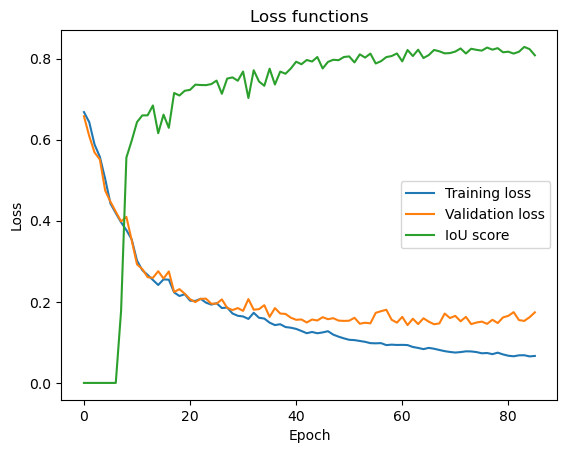


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
- IoU score=0.8598010398092724
- Loss=0.1389890174780573
Hyperparameters [19/24]: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.6604 - VL_loss=0.5805 - IoU=0.0000
Epoch 2/150: TR_loss=0.5345 - VL_loss=0.4925 - IoU=0.0937
Epoch 3/150: TR_loss=0.4468 - VL_loss=0.4285 - IoU=0.4670
Epoch 4/150: TR_loss=0.4267 - VL_loss=0.4186 - IoU=0.4339
Epoch 5/150: TR_loss=0.4096 - VL_loss=0.4011 - IoU=0.4698
Epoch 6/150: TR_loss=0.3992 - VL_loss=0.3885 - IoU=0.4598
Epoch 7/150: TR_loss=0.3744 - VL_loss=0.3659 - IoU=0.5124
Epoch 8/150: TR_loss=0.3406 - VL_loss=0.3761 - IoU=0.4604
Epoch 9/150: TR_loss=0.3331 - VL_loss=0.4777 - IoU=0.2182
Epoch 10/150: TR_loss=0.3110 - VL_loss

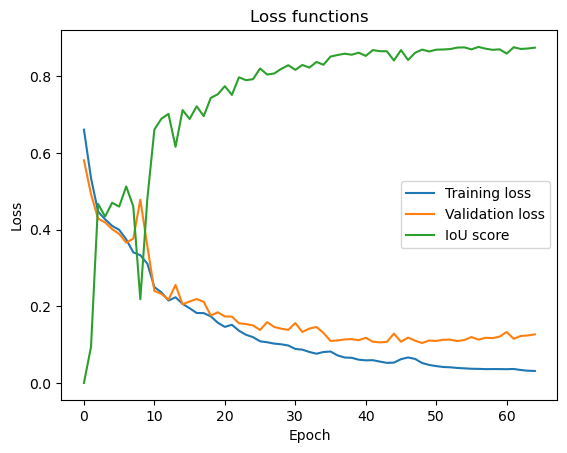


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
- IoU score=0.8724353881109329
- Loss=0.12671430994357383
Hyperparameters [20/24]: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.6041 - VL_loss=0.5558 - IoU=0.0000
Epoch 2/150: TR_loss=0.5035 - VL_loss=0.4588 - IoU=0.2733
Epoch 3/150: TR_loss=0.4495 - VL_loss=0.4287 - IoU=0.4912
Epoch 4/150: TR_loss=0.4501 - VL_loss=0.4180 - IoU=0.4681
Epoch 5/150: TR_loss=0.4223 - VL_loss=0.4090 - IoU=0.5164
Epoch 6/150: TR_loss=0.4222 - VL_loss=0.4039 - IoU=0.5242
Epoch 7/150: TR_loss=0.4043 - VL_loss=0.3920 - IoU=0.5338
Epoch 8/150: TR_loss=0.3842 - VL_loss=0.3408 - IoU=0.5349
Epoch 9/150: TR_loss=0.4076 - VL_loss=0.3985 - IoU=0.4138
Epoch 10/150: TR_loss=0.3677 - 

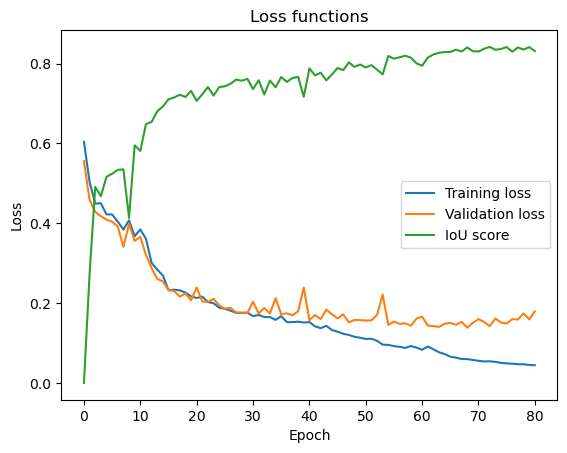


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
- IoU score=0.8724353881109329
- Loss=0.12671430994357383
Hyperparameters [21/24]: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.6382 - VL_loss=0.5817 - IoU=0.0000
Epoch 2/150: TR_loss=0.5346 - VL_loss=0.4830 - IoU=0.1652
Epoch 3/150: TR_loss=0.4234 - VL_loss=0.3763 - IoU=0.5038
Epoch 4/150: TR_loss=0.3231 - VL_loss=0.3028 - IoU=0.6234
Epoch 5/150: TR_loss=0.2902 - VL_loss=0.3009 - IoU=0.6344
Epoch 6/150: TR_loss=0.2845 - VL_loss=0.2768 - IoU=0.6554
Epoch 7/150: TR_loss=0.2662 - VL_loss=0.2661 - IoU=0.6463
Epoch 8/150: TR_loss=0.2533 - VL_loss=0.2607 - IoU=0.6551
Epoch 9/150: TR_loss=0.2571 - VL_loss=0.2691 - IoU=0.6130
Epoch 10/150: TR_loss=0.2457 - 

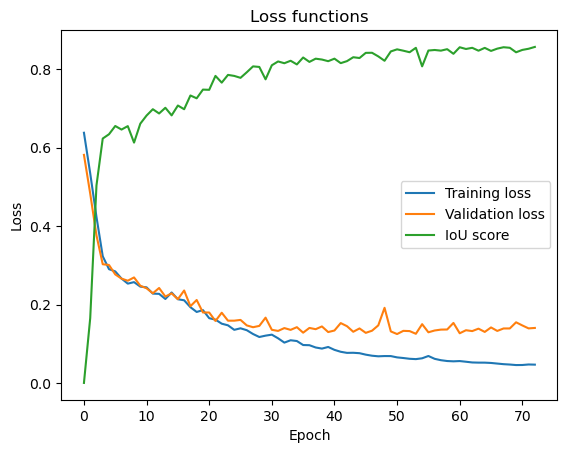


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
- IoU score=0.8724353881109329
- Loss=0.12671430994357383
Hyperparameters [22/24]: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.6444 - VL_loss=0.6059 - IoU=0.0000
Epoch 2/150: TR_loss=0.5855 - VL_loss=0.5481 - IoU=0.0000
Epoch 3/150: TR_loss=0.5084 - VL_loss=0.4652 - IoU=0.5311
Epoch 4/150: TR_loss=0.4181 - VL_loss=0.3946 - IoU=0.5270
Epoch 5/150: TR_loss=0.3702 - VL_loss=0.3781 - IoU=0.4915
Epoch 6/150: TR_loss=0.3382 - VL_loss=0.3329 - IoU=0.5853
Epoch 7/150: TR_loss=0.3156 - VL_loss=0.3381 - IoU=0.5914
Epoch 8/150: TR_loss=0.3028 - VL_loss=0.3057 - IoU=0.5945
Epoch 9/150: TR_loss=0.2920 - VL_loss=0.2957 - IoU=0.6076
Epoch 10/150: TR_loss=0.2821 -

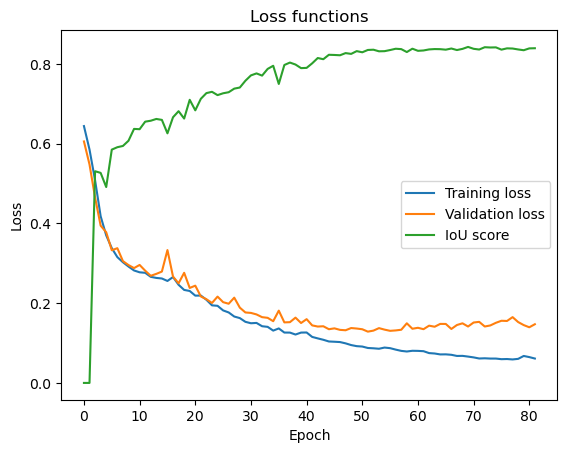


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
- IoU score=0.8724353881109329
- Loss=0.12671430994357383
Hyperparameters [23/24]: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.5493 - VL_loss=0.5679 - IoU=0.4462
Epoch 2/150: TR_loss=0.4758 - VL_loss=0.4782 - IoU=0.2859
Epoch 3/150: TR_loss=0.4439 - VL_loss=0.4545 - IoU=0.4663
Epoch 4/150: TR_loss=0.4407 - VL_loss=0.4753 - IoU=0.4957
Epoch 5/150: TR_loss=0.4123 - VL_loss=0.4387 - IoU=0.4074
Epoch 6/150: TR_loss=0.4048 - VL_loss=0.3266 - IoU=0.5531
Epoch 7/150: TR_loss=0.3250 - VL_loss=0.2722 - IoU=0.6428
Epoch 8/150: TR_loss=0.2981 - VL_loss=0.2588 - IoU=0.6476
Epoch 9/150: TR_loss=0.2714 - VL_loss=0.2666 - IoU=0.6133
Epoch 10/150: TR_loss=0.2653 - V

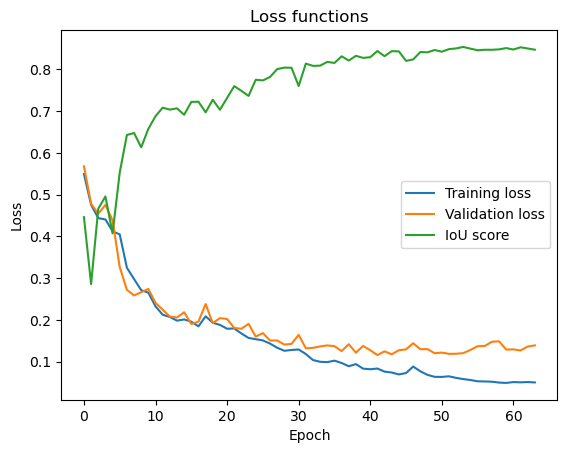


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
- IoU score=0.8724353881109329
- Loss=0.12671430994357383
Hyperparameters [24/24]: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.5835 - VL_loss=0.5372 - IoU=0.0000
Epoch 2/150: TR_loss=0.4991 - VL_loss=0.4412 - IoU=0.0000
Epoch 3/150: TR_loss=0.4670 - VL_loss=0.4517 - IoU=0.0506
Epoch 4/150: TR_loss=0.4086 - VL_loss=0.3876 - IoU=0.4926
Epoch 5/150: TR_loss=0.3700 - VL_loss=0.2885 - IoU=0.6490
Epoch 6/150: TR_loss=0.3136 - VL_loss=0.2933 - IoU=0.6575
Epoch 7/150: TR_loss=0.2584 - VL_loss=0.2425 - IoU=0.6937
Epoch 8/150: TR_loss=0.2268 - VL_loss=0.2322 - IoU=0.7050
Epoch 9/150: TR_loss=0.2267 - VL_loss=0.2398 - IoU=0.7051
Epoch 10/150: TR_loss=0.2289 - 

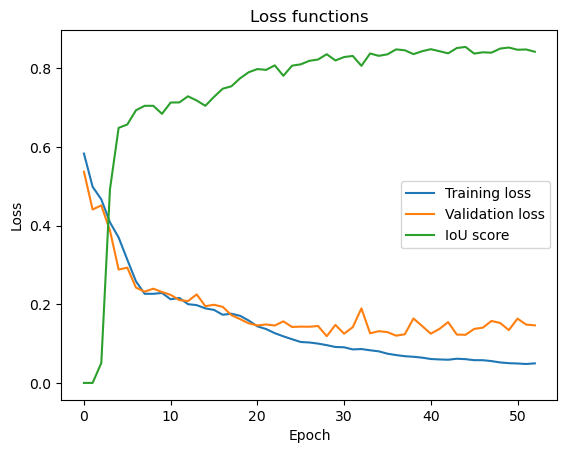


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
- IoU score=0.8724353881109329
- Loss=0.12671430994357383


Model selection result:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
- IoU score=0.8724353881109329
- Loss=0.12671430994357383


In [ ]:
def get_params_combinations(params: dict) -> list[dict]:
    '''
    Creates and saves into the class instance a list with all the possible combinations of parameters \
    in the dictionary "params".

    Parameters:
    - params: dictionary with the parameters as associations <key:values> (with: key=parameter_name,
    values=possible_values_list).

    Returns:
    A list of dictionaries such that each one represents a combination of parameters (1 combination = 1 dictionary).
    '''
    params_index_dict = {}
    params_combinations = []
    for key in params.keys():
        params_index_dict[key] = 0 # current_index for that key
    while sum([index+1 for _, index in params_index_dict.items()]) != sum(len(val_list) for _, val_list in params.items()):
        params_i = {}
        for key, i in params_index_dict.items():
            params_i[key] = params[key][i]
        params_combinations.append(params_i)
        for key in params_index_dict.keys():
            params_index_dict[key] += 1
            if params_index_dict[key] < len(params[key]):
                break
            params_index_dict[key] = 0
    params_i = {}
    for key, i in params_index_dict.items():
        params_i[key] = params[key][i]
    params_combinations.append(params_i)
    return params_combinations


def show_plots(values_list: list[list], labels: list[str]):
    '''
    Shows the plots of the values in the list "values_list". Each list in "values_list" is plotted with
    the corresponding label in "labels".

    Parameters:
    - values_list: list of lists with the values to plot.
    - labels: list of labels for each plot.
    '''
    for i, values in enumerate(values_list):
        plt.plot(values, label=labels[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss functions')
    plt.show()


# Iterates on each parameters combination obtained from the parameters space
tr_dataset, vl_dataset, ts_dataset = random_split(horse_dataset, [0.70,0.15,0.15])
params_list = get_params_combinations(params_space)
model_i = None
best_model_obj = {'iou_scores': [0]}
for i, params in enumerate(params_list):
    print(f'Hyperparameters [{i+1}/{len(params_list)}]: {params}')

    # Datasets initializations
    tr_loader = DataLoader(tr_dataset, batch_size=params['batch_size'], shuffle=True)
    vl_loader = DataLoader(vl_dataset, batch_size=params['batch_size'], shuffle=False)

    # Create the model
    #model = ConvolutionalAE(**params['architecture'])
    model = UNet(kernel_size=params['kernel_size'], features=params['features'], activation=params['activation'])
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = torch.nn.BCELoss()

    # Training phase
    tr_losses, vl_losses, iou_scores = train(
        model,
        tr_dataloader=tr_loader,
        vl_dataloader=vl_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        epochs=params['epochs'],
        threshold=params['threshold'],
        tolerance=params['tolerance'],
        verbose=2
    )

    # Save the model and the parameters
    model_i = {
        'model': model,
        'params': params,
        'tr_losses': tr_losses,
        'vl_losses': vl_losses,
        'iou_scores': iou_scores
    }

    # Shows the Loss plots
    show_plots(
        values_list=[tr_losses,vl_losses,iou_scores],
        labels=['Training loss','Validation loss','IoU score']
    )

    # Save the model if is the best one (based on the highest mean of the last 3 IoU score)
    mean_iou_best_score = np.mean(best_model_obj['iou_scores'][-3:])
    mean_iou_score = np.mean(iou_scores[-3:])
    if mean_iou_best_score < mean_iou_score:
        best_model_obj = model_i
    print(f'\nBest model:\n- Hyperparameters={best_model_obj["params"]}\n- IoU score={np.mean(best_model_obj["iou_scores"][-3:])}\n- Loss={best_model_obj["vl_losses"][-1]}')

## Model evaluation

The following code evaluates the best model chosen in the Model selection.

The "evaluate" method shows the predicted masks for the first images (10 by default) of the Test set and returns the average of the IoU score and the average of the loss.

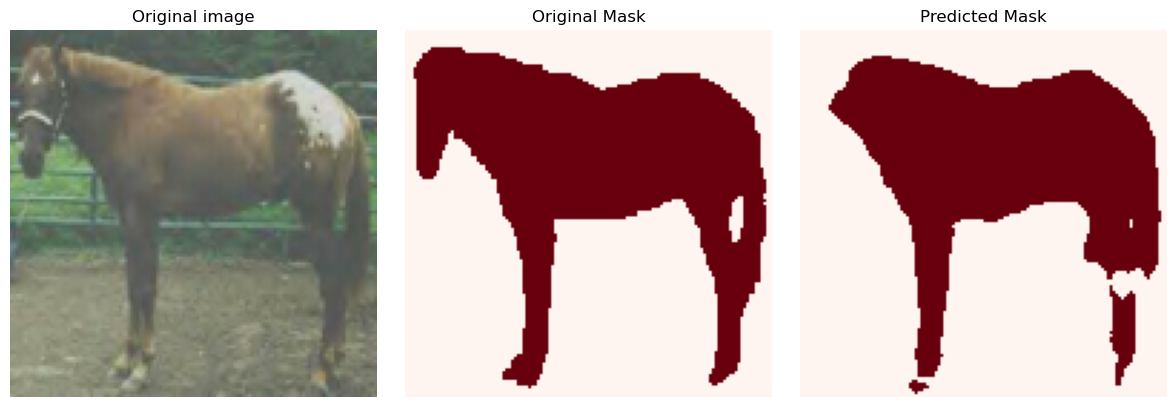

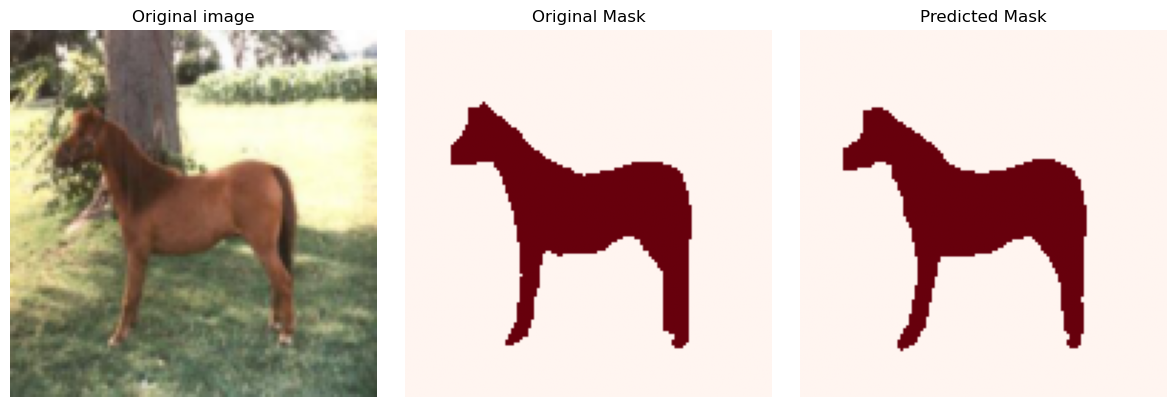

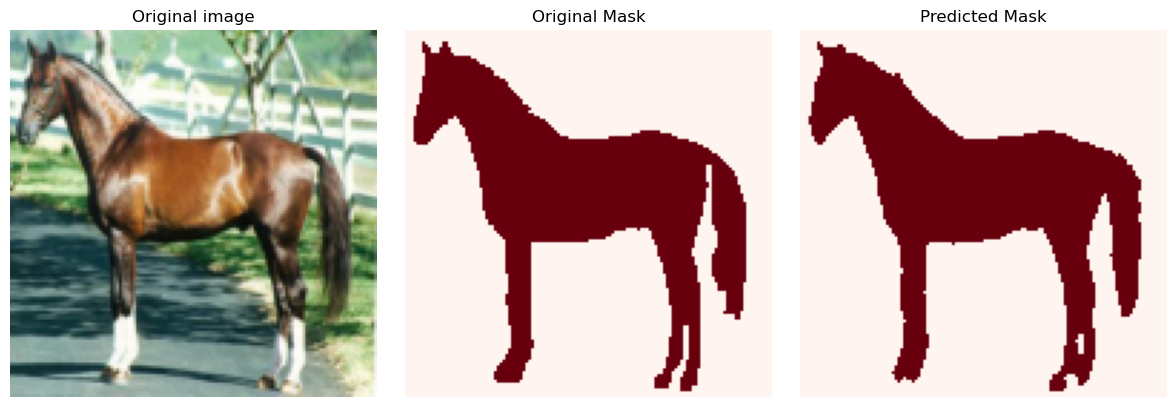

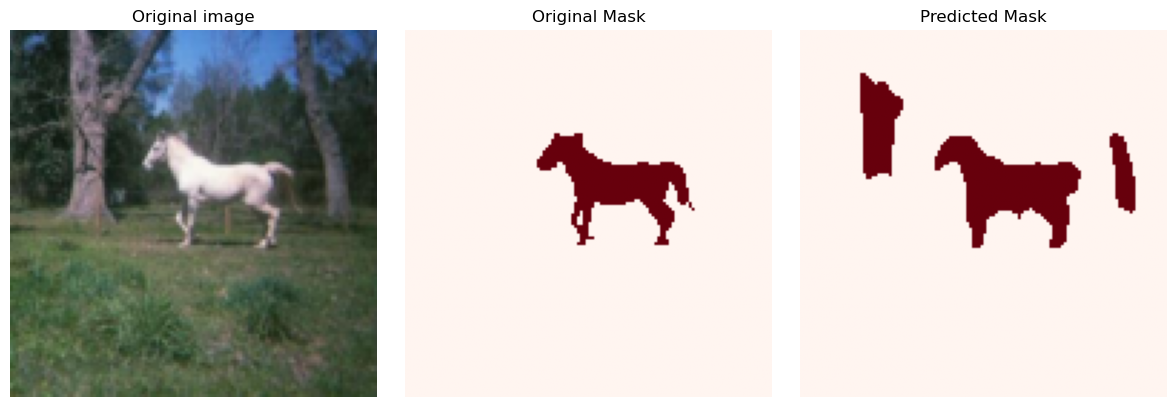

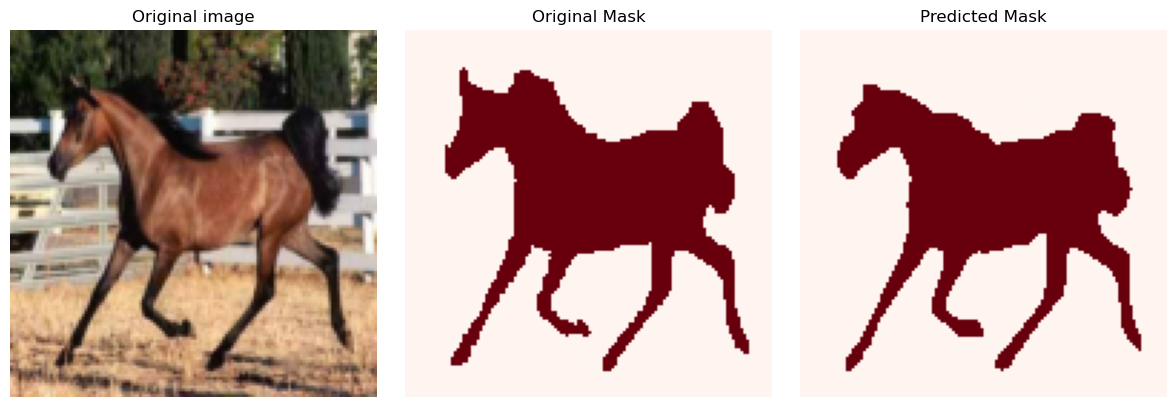

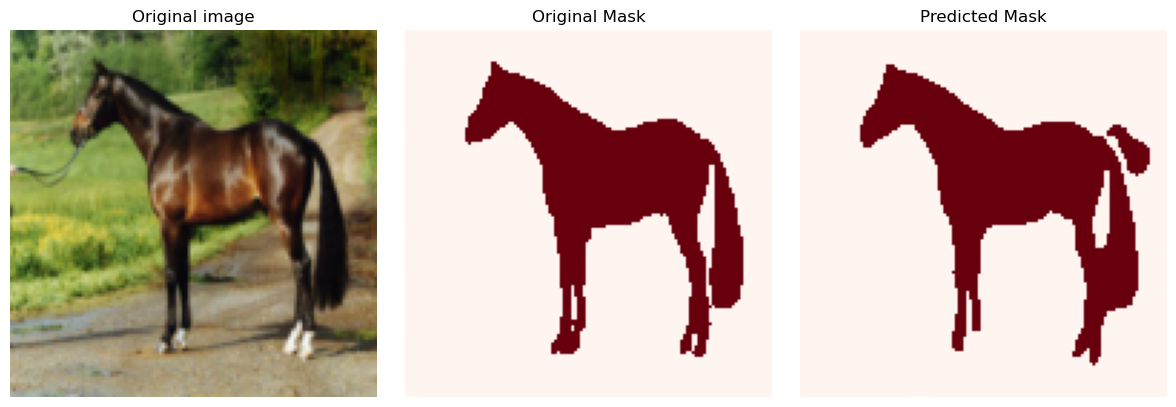

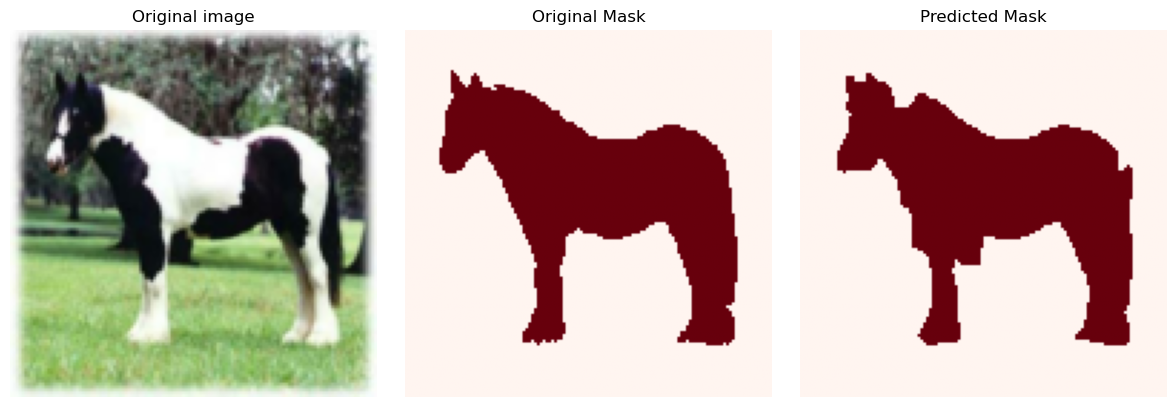

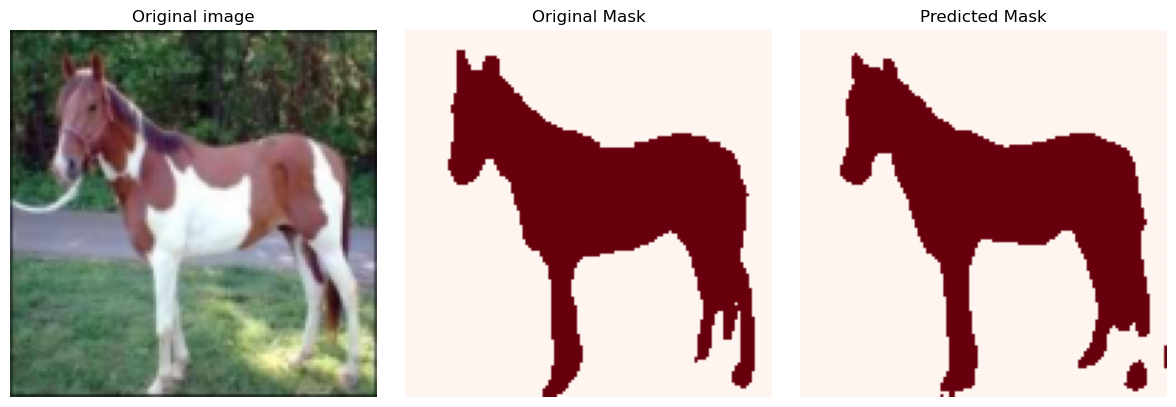

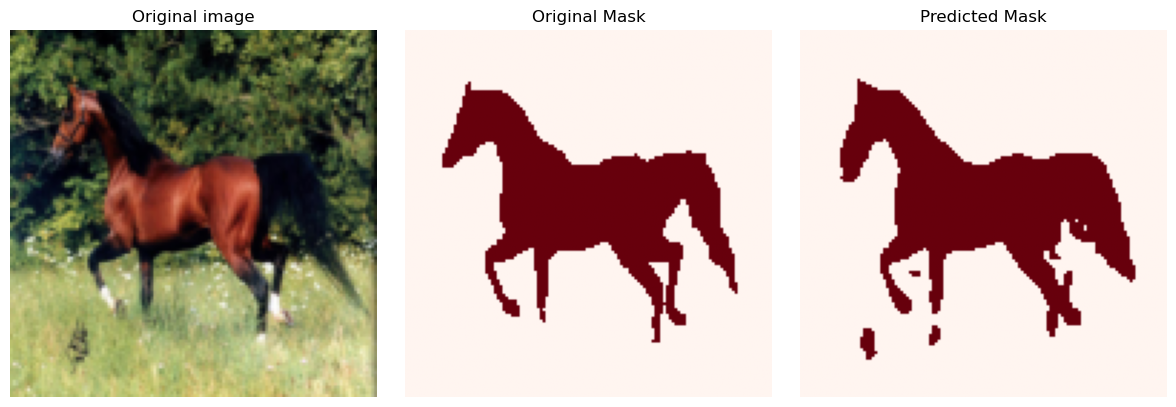

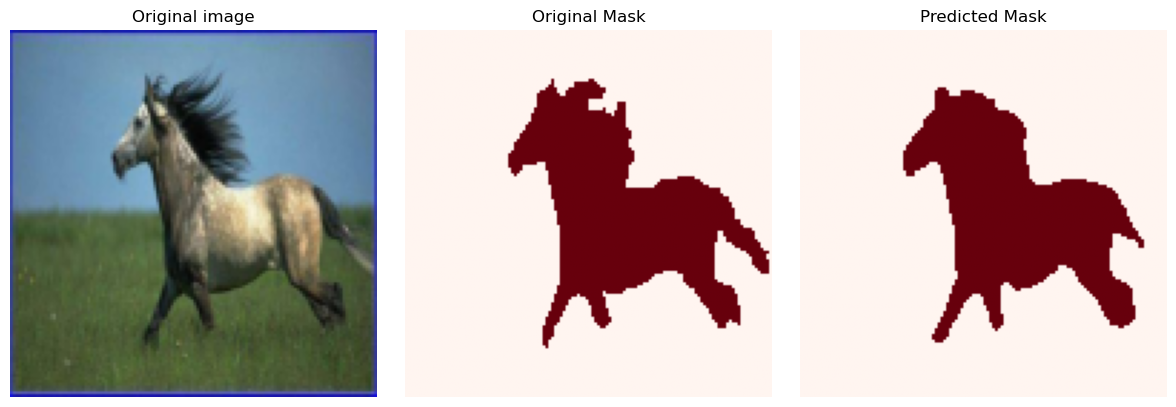

Best model parameters: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 7, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Test Loss: 0.11867729521223477
Test IoU score: 0.8866315739495414


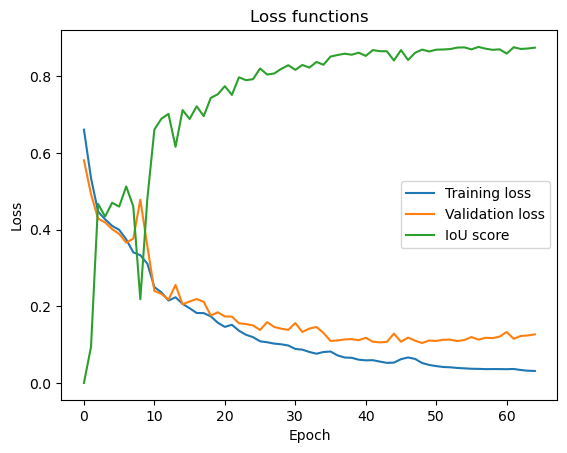

In [ ]:
def show_prediction_plot(img: torch.Tensor, mask: torch.Tensor, pred: torch.Tensor):
    '''
    Shows the original image, the original mask and the predicted mask passed as parameters.

    Parameters:
    - img (torch.Tensor): the original image.
    - mask (torch.Tensor): the original mask.
    - pred (torch.Tensor): the predicted mask.
    '''
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img)
    axs[0].set_title('Original image')
    axs[0].axis('off')
    axs[1].imshow(mask, cmap='Reds')
    axs[1].set_title('Original Mask')
    axs[1].axis('off')
    axs[2].imshow(pred, cmap='Reds')
    axs[2].set_title('Predicted Mask')
    axs[2].axis('off')
    plt.tight_layout()
    plt.show()



def denormalize(img: torch.Tensor, dataset: Dataset) -> torch.Tensor:
    '''
    Denormalizes the image passed as parameter based on the mean and standard deviation of the dataset.
    
    Parameters:
    - img (torch.Tensor): the image to denormalize.
    - dataset (Dataset): the dataset of the image from which the mean and std are taken.
    '''
    mean, std = dataset.mean, dataset.std
    for tensor, m, s in zip(img, mean, std):
        tensor.mul_(s).add_(m)
    return img



def evaluate(model: nn.Module, ts_dataloader: DataLoader, criterion, device, n_imgs_to_show=10):
    '''
    Test the model on the test set. The model is evaluated using the IoU score.

    Parameters:
    - model (nn.Module): the model to evaluate.
    - ts_dataloader (DataLoader): the test set.
    - criterion: the loss function to use.
    - device: the device to use (CPU or GPU).
    - n_imgs_to_show: the number of images of which show the predictions.

    Returns:
    - iou_avg_score: the average IoU score.
    - avg_loss: the average loss.
    '''
    model.eval()
    model.to(device)

    # Initializations
    total_loss = 0.0
    total_iou = 0.0
    shown = 0

    with torch.no_grad():
        for imgs, masks in ts_dataloader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            # Compute the predictions and the loss
            preds = model(imgs)
            loss = criterion(preds, masks)
            total_loss += loss.item()

            # Binarization of the predictions
            preds = (preds > 0.5).float()

            # Case of plot of the images
            if shown < n_imgs_to_show:
                # Matplotlib can't handle GPU tensors (so we need to move them to CPU)
                imgs_cpu = imgs.cpu()
                masks_cpu = masks.cpu()
                preds_cpu = preds.cpu()
                # Plot the images
                for img, mask, pred in zip(imgs_cpu, masks_cpu, preds_cpu):
                    mask = (mask > 0.5).float()
                    pred = (pred > 0.5).float()
                    if shown == n_imgs_to_show:
                        break
                    img = denormalize(img, horse_dataset)
                    show_prediction_plot(img.permute(1,2,0), mask[0], pred[0])
                    shown += 1

            # Compute the number of correct pixels predicted
            total_iou += iou(preds, masks)

    # Accuracy and average loss
    iou_avg_score = total_iou / len(ts_dataloader)
    avg_loss = total_loss / len(ts_dataloader)
    return iou_avg_score, avg_loss



# Create the test dataloader
ts_loader = DataLoader(ts_dataset, batch_size=best_model_obj['params']['batch_size'], shuffle=False)

# Evaluation phase
iou_score, avg_loss = evaluate(
    model=best_model_obj['model'],
    ts_dataloader=ts_loader,
    criterion=criterion,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

# Show the results
print(f'Best model parameters: {best_model_obj["params"]}')
print(f'Test Loss: {avg_loss}')
print(f'Test IoU score: {iou_score}')
show_plots(
    values_list=[best_model_obj['tr_losses'], best_model_obj['vl_losses'], best_model_obj['iou_scores']],
    labels=['Training loss', 'Validation loss', 'IoU score']
)

## Conclusions

The U-Net architecture demonstrated strong performance in segmenting horses from the background, achieving a IoU score of 86.49%. The model accurately captures the overall shape of the horse across different poses and backgrounds, although some fine details are missed.

These results confirm the effectiveness of UNets for binary semantic segmentation tasks. The skip connections highlight the importance of recovering details lost during downsampling, a feature that is absent in standard CAE architectures.